# Predicting Aircraft Engine's Time To Failure (TTF)

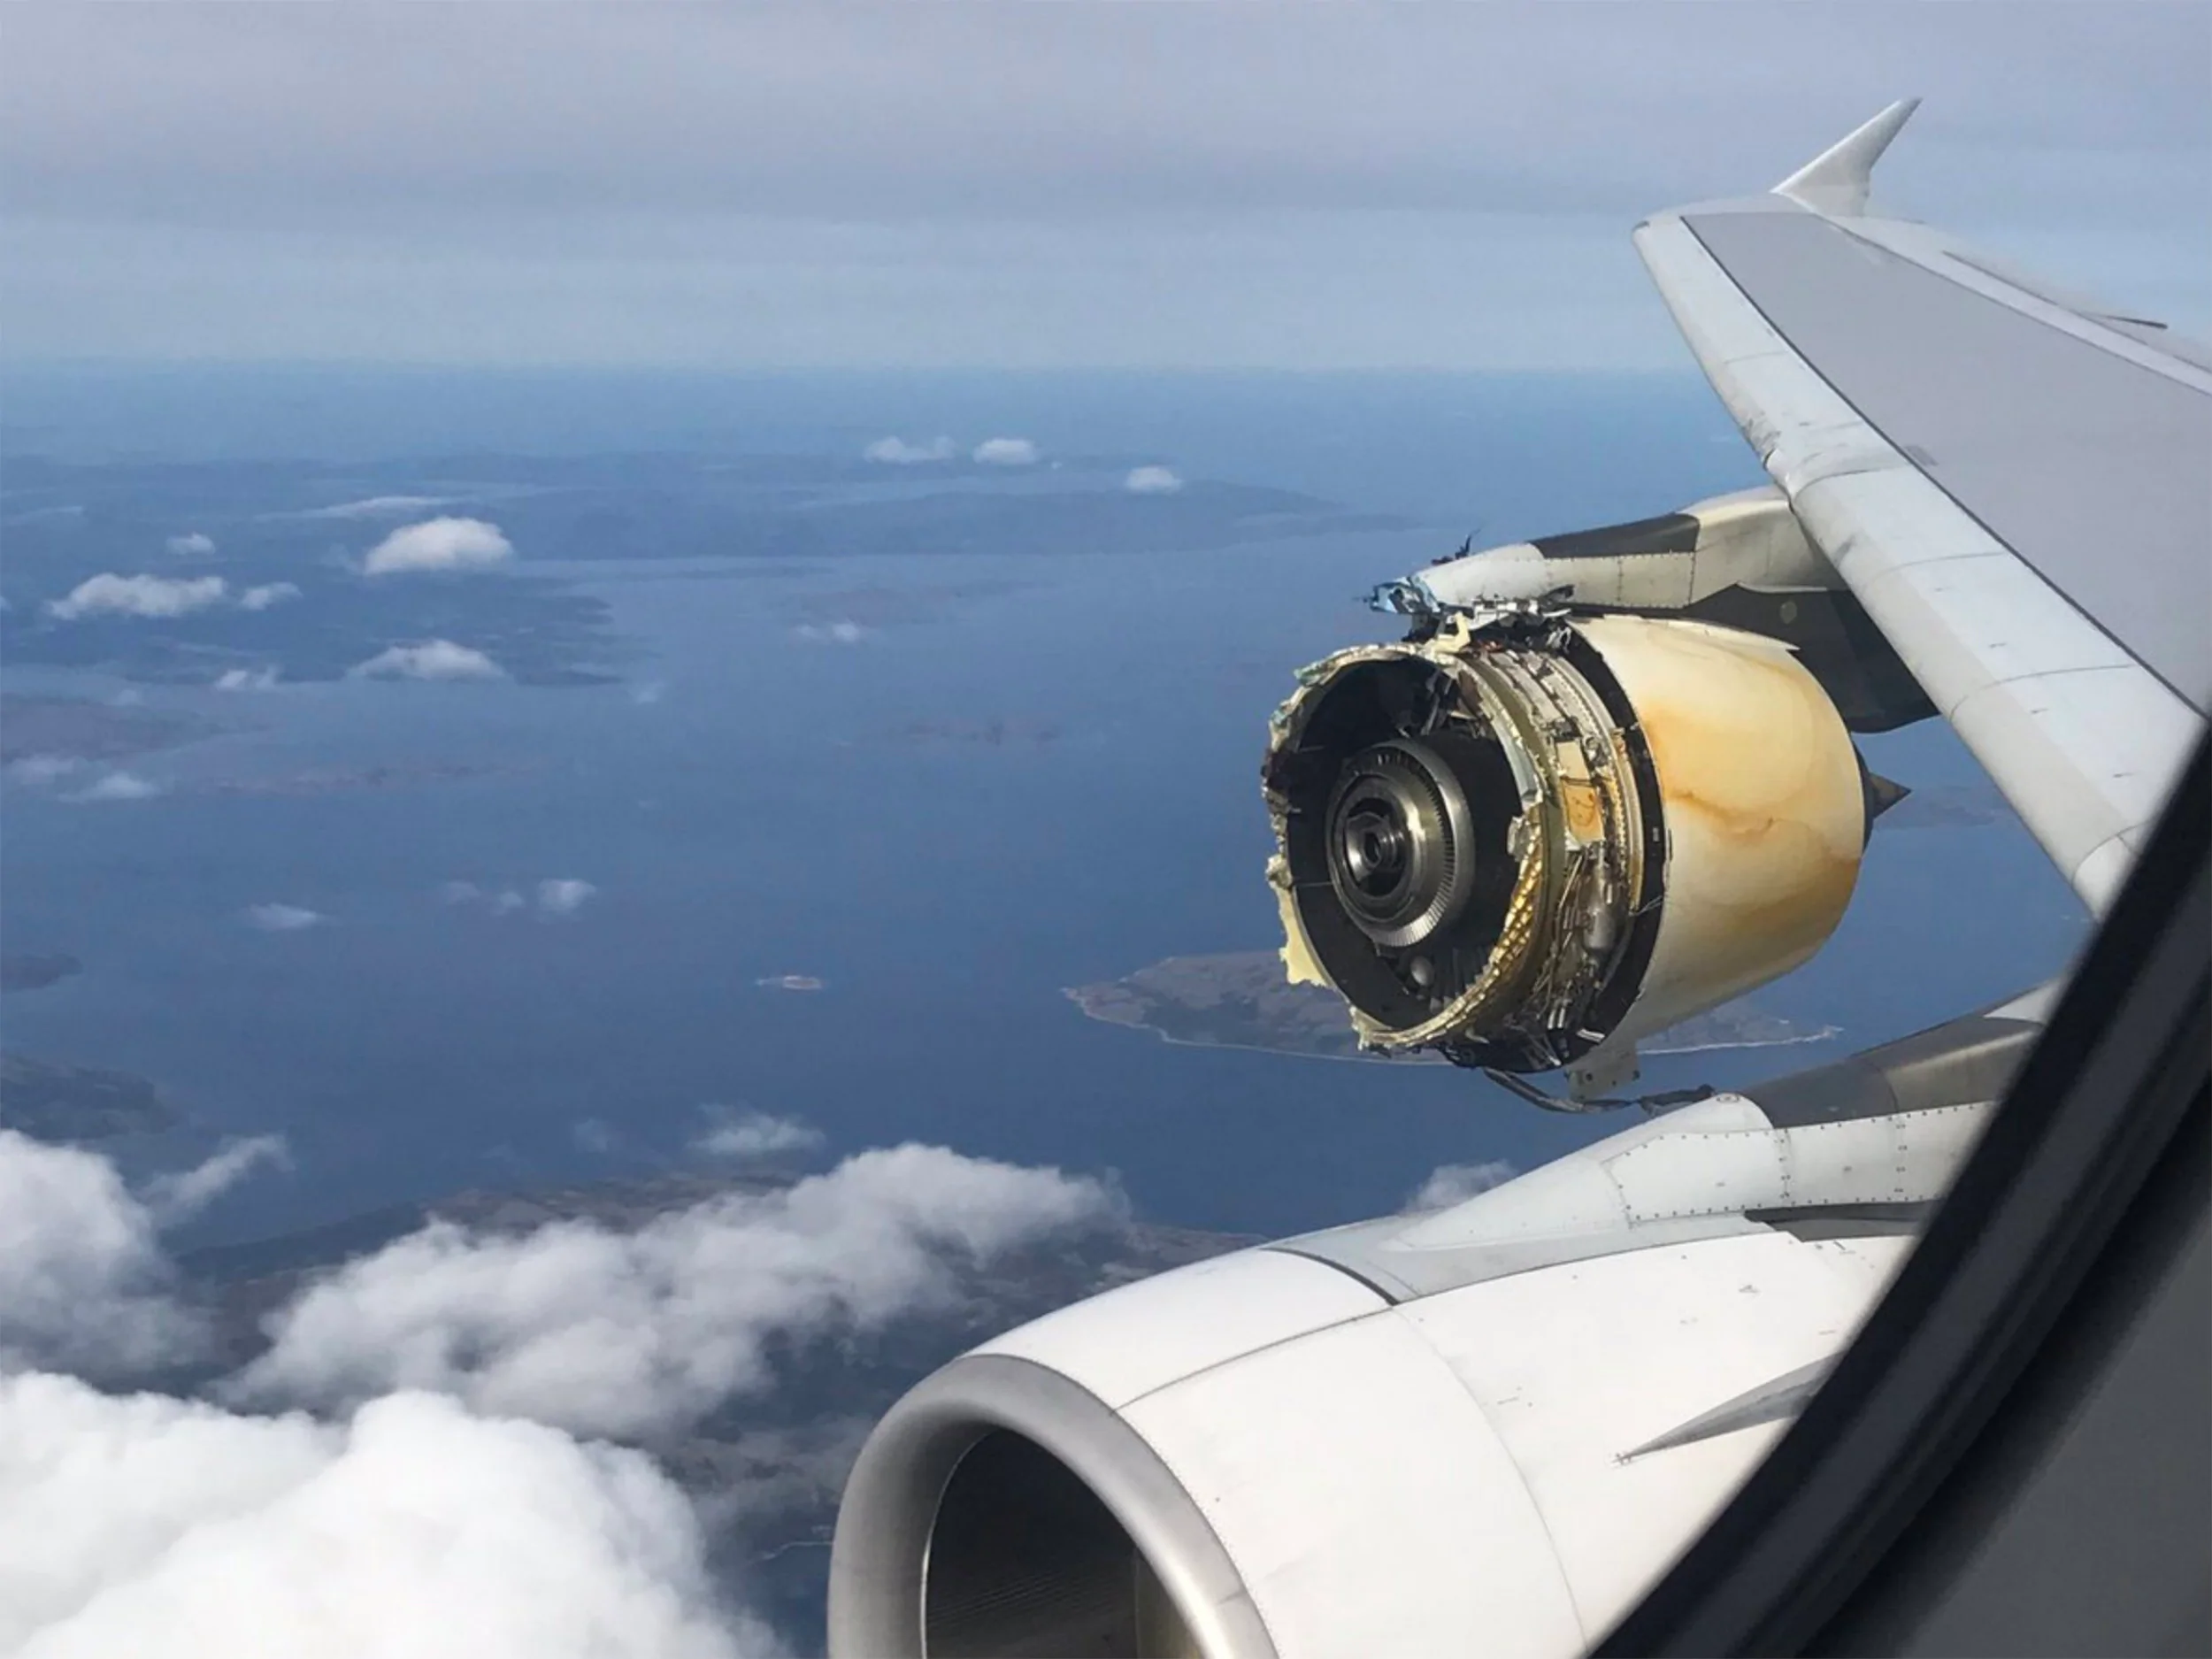

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  
from sklearn import linear_model
from sklearn import model_selection #import cross_val_score, StratifiedKFold
from sklearn import metrics  # mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score


### Load Data:

In [2]:
# load training data prepared previously
df_train = pd.read_csv('train.csv')
df_train.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   

      s5  ...      sd15  sd16      sd17  sd18  sd19      sd20      sd21  ttf  \
0  14.62  ...  0.000000   0.0  0.000000   0.0   0.0  0.000000  0.000000  191   
1  14.62  ...  0.008697   0.0  0.000000   0.0   0.0  0.042426  0.003253  190   
2  14.62  ...  0.007640   0.0  1.154701   0.0   0.0  0.055076  0.044573  189   
3  14.62  ...  0.028117   0.0  1.000000   0.0   0.0  0.076322  0.037977  188   
4  14.62  ...  0.025953   0.0  1.095445   0.0   0.0  0.073621  0.033498  187   

   label_bnc  label_mcc  
0          0          0  
1          0          0  
2          0          0  
3          0          0  
4          0          0  

[5 rows x 71 columns]

In [3]:
# load test data prepared previously
df_test = pd.read_csv('test.csv')
df_test.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1     31   -0.0006    0.0004     100.0  518.67  642.58  1581.22  1398.91   
1   2     49    0.0018   -0.0001     100.0  518.67  642.55  1586.59  1410.83   
2   3    126   -0.0016    0.0004     100.0  518.67  642.88  1589.75  1418.89   
3   4    106    0.0012    0.0004     100.0  518.67  642.78  1594.53  1406.88   
4   5     98   -0.0013   -0.0004     100.0  518.67  642.27  1589.94  1419.36   

      s5  ...      sd15  sd16      sd17  sd18  sd19      sd20      sd21  ttf  \
0  14.62  ...  0.021174   0.0  0.707107   0.0   0.0  0.124016  0.025037  112   
1  14.62  ...  0.011429   0.0  1.095445   0.0   0.0  0.069785  0.027820   98   
2  14.62  ...  0.030924   0.0  0.836660   0.0   0.0  0.143631  0.018966   69   
3  14.62  ...  0.021249   0.0  1.341641   0.0   0.0  0.126372  0.021106   82   
4  14.62  ...  0.009627   0.0  0.547723   0.0   0.0  0.091924  0.101100   91   

   label_bnc  label_mcc  
0          0          0  
1          0          0  
2          0          0  
3          0          0  
4          0          0  

[5 rows x 71 columns]

### Regression Modelling:

Segment training and test data into features dataframe and labels series.  

To make it easy to train models on different set of features, a variable to hold the set of features required was used to subset the original dataframes

In [4]:
#Prepare data for regression model

# original features
features_orig = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_adxf = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd16', 'sd17', 'sd18', 'sd19', 'sd20', 'sd21']

# features with low or no correlation with regression label
features_lowcr = ['setting3', 's1', 's10', 's18','s19','s16','s5', 'setting1', 'setting2']

# features that have correlation with regression label
features_corrl = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20','s21']

# a variable to hold the set of features to experiment with
features = features_orig
X_train = df_train[features]
y_train = df_train['ttf']
X_test = df_test[features]
y_test = df_test['ttf']

Create a helper function to calculate regression metrics

In [5]:
#@title Regression Metric function
def get_regression_metrics(model, actual, predicted):

    regr_metrics = {
                        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                        'R^2' : metrics.r2_score(actual, predicted),
                        'Explained Variance' : metrics.explained_variance_score(actual, predicted)
                   }

    #return reg_metrics
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

Create a helper function to plot the coefficients weights or feature importance

In [6]:
#@title Feature Weight function
def plot_features_weights(model, weights, feature_names, weights_type='c'):

    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None
    

Create a helper function to plot the regression residuals

In [7]:
#@title Residual Function
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):
  
    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
    plt.title(model + ' Residuals')
    plt.show()
     

Using the above functions let us model and evaluate some regression algorithms

# Using Linear Regression

In [8]:
#try linear regression

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics


R^2 training: 0.580, R^2 test: 0.405


Linear Regression
Root Mean Squared Error          32.041095
Mean Absolute Error              25.591780
R^2                               0.405495
Explained Variance                0.665297

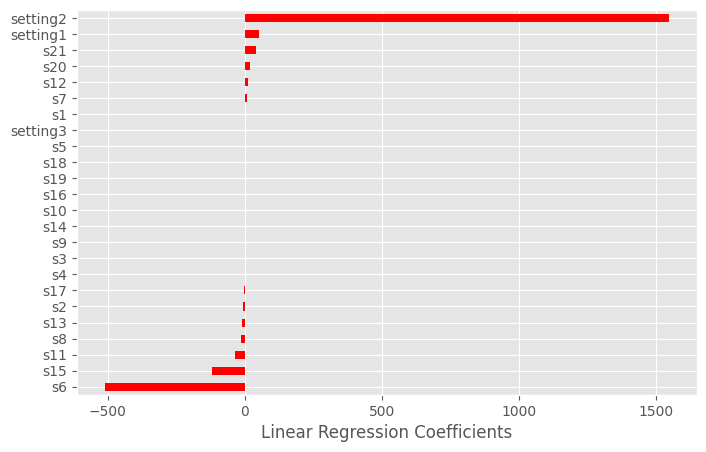

In [9]:
plot_features_weights('Linear Regression', linreg.coef_, X_train.columns, 'c')

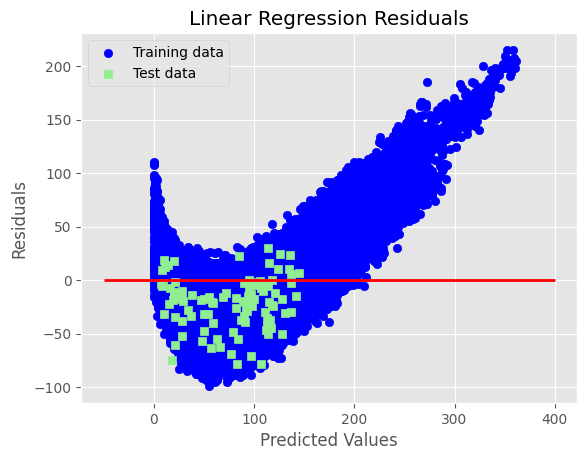

In [10]:
plot_residual('Linear Regression', y_train_predict, y_train, y_test_predict, y_test)

# Using LASSO Regression

In [11]:
#try LASSO

lasso = linear_model.Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

y_test_predict = lasso.predict(X_test)
y_train_predict = lasso.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

lasso_metrics = get_regression_metrics('LASSO', y_test, y_test_predict)

lasso_metrics


R^2 training: 0.579, R^2 test: 0.408


LASSO
Root Mean Squared Error  31.966099
Mean Absolute Error      25.551808
R^2                       0.408275
Explained Variance        0.668206

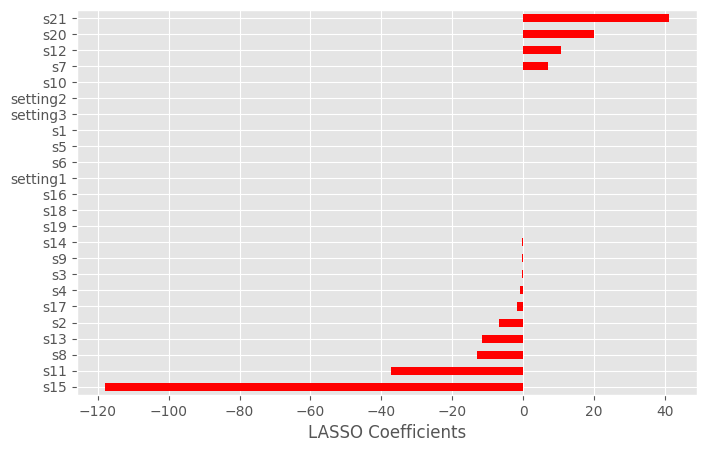

In [12]:
plot_features_weights('LASSO', lasso.coef_, X_train.columns, 'c')

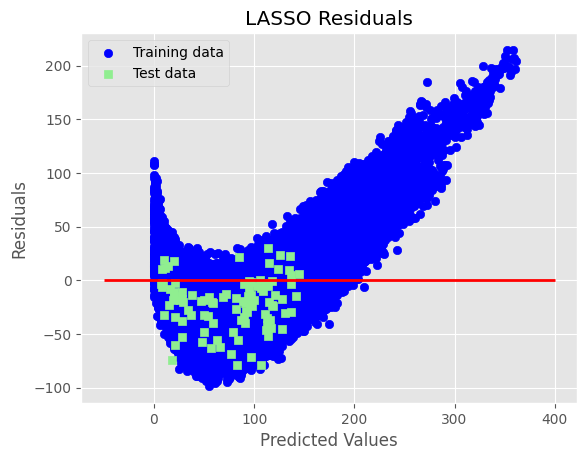

In [13]:
plot_residual('LASSO', y_train_predict, y_train, y_test_predict, y_test)

# Using Ridge Regression

In [14]:
#try ridge

rdg = linear_model.Ridge(alpha=0.01)
rdg.fit(X_train, y_train)

y_test_predict = rdg.predict(X_test)
y_train_predict = rdg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rdg_metrics = get_regression_metrics('Ridge Regression', y_test, y_test_predict)
rdg_metrics

R^2 training: 0.580, R^2 test: 0.408


Ridge Regression
Root Mean Squared Error         31.965740
Mean Absolute Error             25.544620
R^2                              0.408289
Explained Variance               0.667607

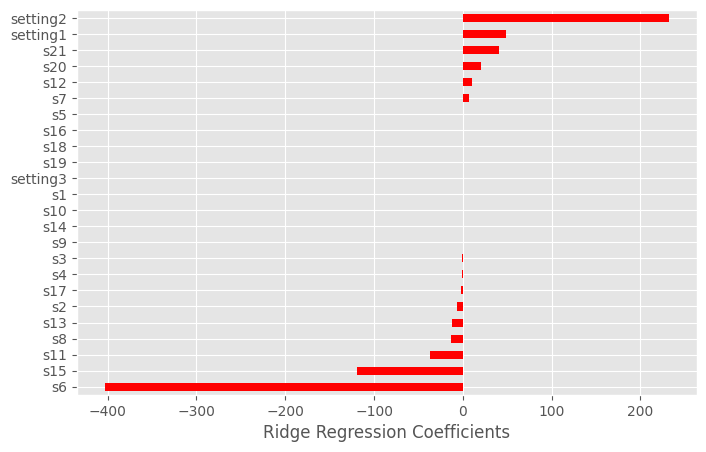

In [15]:
plot_features_weights('Ridge Regression', rdg.coef_, X_train.columns, 'c')

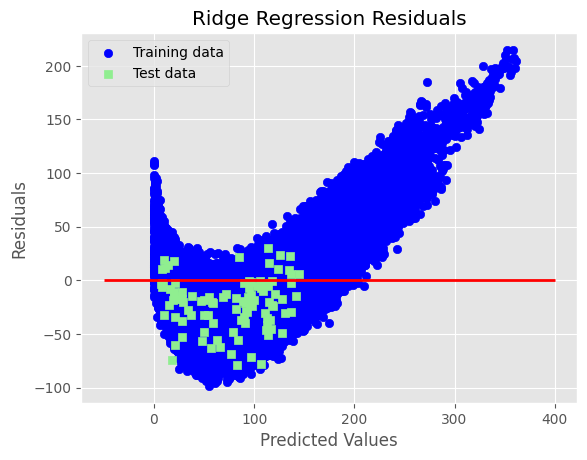

In [16]:
plot_residual('Ridge Regression', y_train_predict, y_train, y_test_predict, y_test)

# Using Polynomial Regression

In [17]:
#try Polynomial Regression

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

polyreg_metrics = get_regression_metrics('Polynomial Regression', y_test, y_test_predict)
polyreg_metrics

R^2 training: 0.626, R^2 test: 0.429


Polynomial Regression
Root Mean Squared Error              31.405933
Mean Absolute Error                  23.738516
R^2                                   0.428832
Explained Variance                    0.631377

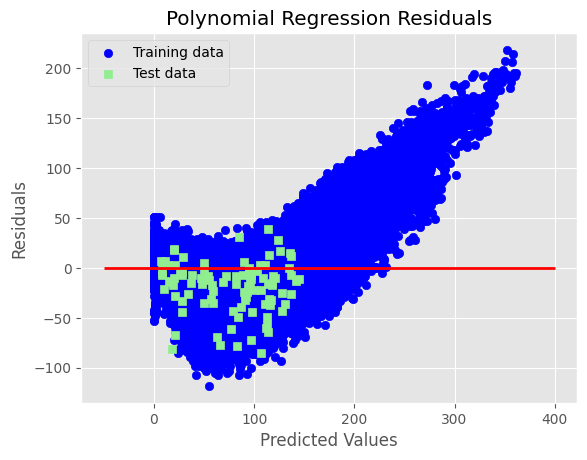

In [18]:
plot_residual('Polynomial Regression', y_train_predict, y_train, y_test_predict, y_test)

Polynomial Regression has scored better than linear models

Regression residuals were not randomly spread across the average value of the residuals. This could be improved by fixing the data (e.g. outliers, resampling) or model parameters tuning.

Let us view predicted values

In [19]:
# view predictions vs actual

poly_pred_dict = {
                'Actual' : y_test,
                'Prediction' : y_test_predict
            }
    
poly_pred = pd.DataFrame.from_dict(poly_pred_dict).T
poly_pred

0          1          2          3           4   \
Actual      112.000000   98.00000  69.000000  82.000000   91.000000   
Prediction  171.742188  142.03125  82.789062  98.421875  123.539062   

                   5           6          7           8           9   ...  \
Actual       93.00000   91.000000  95.000000  111.000000   96.000000  ...   
Prediction  117.59375  118.445312  98.820312  108.570312  109.921875  ...   

                   90         91         92         93          94         95  \
Actual      38.000000  20.000000  85.000000  55.000000  128.000000  137.00000   
Prediction  45.015625  29.851562  53.992188  66.757812  152.796875  163.65625   

                   96         97          98         99  
Actual      82.000000  59.000000  117.000000  20.000000  
Prediction  90.351562  94.671875  149.539062   1.046875  

[2 rows x 100 columns]

# Comparing all regression models tested

In [20]:
#regression metrics comparison before feature engineering
reg_metrics_bfe = pd.concat([linreg_metrics, lasso_metrics, rdg_metrics,  polyreg_metrics], axis=1)
reg_metrics_bfe

Linear Regression      LASSO  Ridge Regression  \
Root Mean Squared Error          32.041095  31.966099         31.965740   
Mean Absolute Error              25.591780  25.551808         25.544620   
R^2                               0.405495   0.408275          0.408289   
Explained Variance                0.665297   0.668206          0.667607   

                         Polynomial Regression  
Root Mean Squared Error              31.405933  
Mean Absolute Error                  23.738516  
R^2                                   0.428832  
Explained Variance                    0.631377

# Conclusion

__Regression Summary:__  

In accordance with our analysis in the data exploratory phase, non-linear regression models like Polynomial performed better than linear models like OLS, LASSO and Ridge regression. Polynomial Regression clearly outperformed other models scoring Mean Absolute Error of 24.94 cycles, i.e. the model predicts TTF within average error range of ±24.94 cycles. However Comparing RMSE, Ridge Regression outperformed even non-linear polynomial model. The value was ±31.9657, which was lesser than others. Comparing Explained Variance, again Polynomial Regression wins (±63.3327%). So we prefer Polynomial Regression model.

The hyper-parameter tuning for the LASSO, and Ridge models was done manually, but Grid Search or Random Search with Cross Validation could be used for better processing.

